# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Random Forest

In [17]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from hyperopt import hp, tpe, STATUS_OK, Trials, space_eval
from hyperopt.fmin import fmin

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter('ignore', UndefinedMetricWarning)

In [18]:
# Set up directories
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [28]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

## Hyperparameter Tuning

Bayesian optimization with `hyperopt`

In [33]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)

In [5]:
# Define objective function
def get_score(space):
    clf = LogisticRegression(**space, random_state=7)
    
    #pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    score = cross_val_score(clf, X, y, cv=cv, scoring='f1', n_jobs=5).mean()
    
    return score

def f(params):
    score = get_score(params)
    return {'loss': -score, 'status': STATUS_OK}

In [6]:
# Define hyperparameter search space
param_space = {
    'C': hp.loguniform('C', np.log(10)*-4, np.log(10)*4),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'solver': hp.choice('solver', ['liblinear', 'saga'])
}

# Begin optimization
trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)

# Obtain parameters of best model
best_params = space_eval(param_space, best)
best_params

100%|██████████| 25/25 [01:50<00:00,  1.77s/it, best loss: -0.7317776535039715]


{'C': 3.1905156918547437,
 'class_weight': None,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [37]:
# Set up classifier
clf = LogisticRegression(**best_params,
                               random_state=7)
clf.set_params(class_weight='balanced')
_ = clf.fit(X, y)

# Dump model as pickle
_ = joblib.dump(clf, 'best.pkl')

LogisticRegression(C=3.1905156918547437, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluate model on partitioned datasets

                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9485    0.8729    0.9091     10777
           1     0.6219    0.8151    0.7055      2764

    accuracy                         0.8611     13541
   macro avg     0.7852    0.8440    0.8073     13541
weighted avg     0.8818    0.8611    0.8675     13541



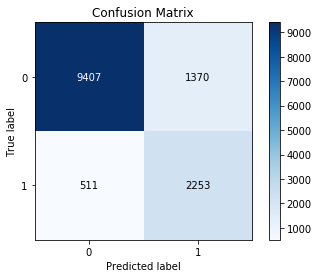

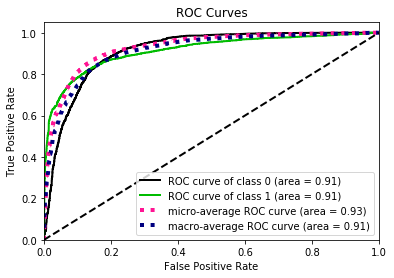

<hr></hr>

                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9576    0.9002    0.9280     13137
           1     0.7005    0.8540    0.7697      3590

    accuracy                         0.8903     16727
   macro avg     0.8290    0.8771    0.8488     16727
weighted avg     0.9024    0.8903    0.8940     16727



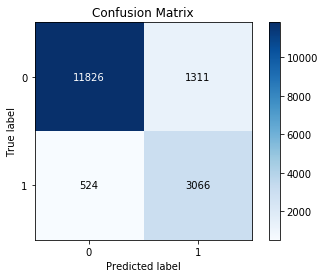

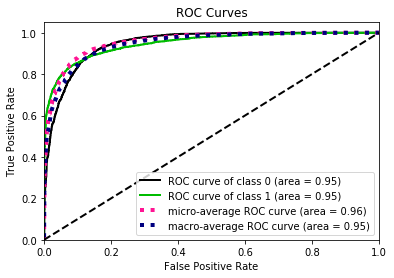

<hr></hr>

                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9633    0.9229    0.9427      3500
           1     0.7976    0.8964    0.8441      1187

    accuracy                         0.9162      4687
   macro avg     0.8805    0.9096    0.8934      4687
weighted avg     0.9213    0.9162    0.9177      4687



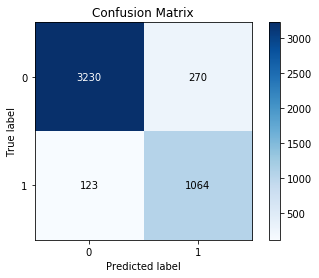

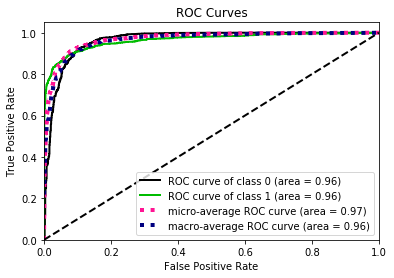

<hr></hr>

In [38]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier
    #_ = clf.fit(X_train, y_train)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))